In [1]:
#https://github.com/keras-team/keras/releases
!pip install q keras==2.11.0
!pip install tensorflow==2.9.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.8/511.8 MB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 KB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 70.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 96.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 KB 37.2 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.11.0
    Uninstalling keras-2.11.0:
      Successfully uninstalled keras-2.11.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 23.3.3
    Uninstalling flatbuffers-23.3.3:
      Successfully uninstalled flatbuffers-23.3.3
  Attempting uninstall: tensorflow-estimator
    Found existing installation

In [2]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
import keras
from keras import layers 
import tensorflow as tf
from keras.models import Model
from keras.optimizers import Adam, SGD

In [3]:
print("Tensorflow version " + tf.__version__)
np.random.seed(123)
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

Tensorflow version 2.9.2
Running on TPU  ['10.83.23.2:8470']


In [4]:
# requires training and test data with metadata

rating_df = pd.read_csv('meta_train.csv')
rating_df = rating_df.rename(columns={'User':'u_id','ChannelName':'s_id','z_score_scaled':'rate'})
rating_df.head()

test_df = pd.read_csv('meta_test.csv')
test_df = test_df.rename(columns={'User':'u_id','ChannelName':'s_id','z_score_scaled':'rate'})
test_df.head()

rating_df['Frequency'] = (rating_df['Frequency'] - rating_df['Frequency'].min()) / (rating_df['Frequency'].max() - rating_df['Frequency'].min())    
rating_df['User_Deg'] = (rating_df['User_Deg'] - rating_df['User_Deg'].min()) / (rating_df['User_Deg'].max() - rating_df['User_Deg'].min())    
rating_df['Channel_Deg'] = (rating_df['Channel_Deg'] - rating_df['Channel_Deg'].min()) / (rating_df['Channel_Deg'].max() - rating_df['Channel_Deg'].min())    

test_df['Frequency'] = (test_df['Frequency'] - test_df['Frequency'].min()) / (test_df['Frequency'].max() - test_df['Frequency'].min())    
test_df['User_Deg'] = (test_df['User_Deg'] - test_df['User_Deg'].min()) / (test_df['User_Deg'].max() - test_df['User_Deg'].min())    
test_df['Channel_Deg'] = (test_df['Channel_Deg'] - test_df['Channel_Deg'].min()) / (test_df['Channel_Deg'].max() - test_df['Channel_Deg'].min())  
rating_df.isnull().values.any()
test_df.isnull().values.any()


False

In [5]:
# model requires a random seed
rating_df = rating_df.sample(frac=1, random_state=73)
rating_df.s_id = pd.Categorical(rating_df.s_id)
rating_df['s_id'] = rating_df.s_id.cat.codes
rating_df.dtypes
X = rating_df[['u_id', 's_id','Frequency','User_Deg','Channel_Deg']].values #,
y = rating_df["rate"]

test_df = test_df.sample(frac=1, random_state=73)
test_df.s_id = pd.Categorical(test_df.s_id)
test_df['s_id'] = test_df.s_id.cat.codes
test_df.dtypes
test_in_u = test_df['u_id'].values #,'Frequency','User_Deg','Channel_Deg'
test_in_s = test_df['s_id'].values
test_in_f = test_df['Frequency'].values
test_in_ud = test_df['User_Deg'].values
test_in_cd = test_df['Channel_Deg'].values
test_rating = test_df["rate"]

In [6]:
# traing and validation split lifted from: https://www.kaggle.com/code/chaitanya99/recommendation-system-cf-anime
test_set_size = 10000 #10k for test set
train_indices = rating_df.shape[0] - test_set_size 

X_train, X_val, y_train, y_val = (
    X[:train_indices],
    X[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

# Alternative with sklearn
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y,
#                                                     stratify=y, 
#                                                     test_size=0.25)

print('> Train set ratings: {}'.format(len(y_train)))
print('> Test set ratings: {}'.format(len(y_val)))

> Train set ratings: 1419900
> Test set ratings: 10000


In [7]:
X_train_array = [X_train[:, 0], X_train[:, 1],X_train[:, 2],X_train[:, 3],X_train[:, 4]]
X_val_array = [X_val[:, 0], X_val[:, 1],X_val[:, 2],X_val[:, 3],X_val[:, 4]]

In [8]:
#from: https://github.com/hexiangnan/neural_collaborative_filtering/blob/4aab159e81c44b062c091bdaed0ab54ac632371f/NeuMF.py#L158
in_u_dim = len(rating_df["u_id"].unique())
in_s_dim = len(rating_df["s_id"].unique())
 
latent_out_dim = 8 #embedding size

# Embedding(input_dim = num_items
# num_users, num_items = train.shape
# output_dim = mf_dim
# mf = 10

In [9]:
# Embedding layers
from keras.layers import Add, Activation, Lambda, BatchNormalization, Concatenate, Dropout, Input, Embedding, Dot, Reshape, Dense, Flatten
from keras import regularizers

def ncf(): 
    
    user_gmf = Input(name = 'u_in_gmf', shape = [1])
    stream_gmf = Input(name = 's_in_gmf', shape = [1])
    frequency_gmf = Input(name = 'f_in_gmf', shape = [1])
    user_deg_gmf = Input(name = 'ud_in_gmf', shape = [1])
    channel_deg_gmf = Input(name = 'cd_in_gmf', shape = [1])

    user_embedding_gmf = Embedding(name = 'u_emb_gmf', embeddings_regularizer=regularizers.L2(0), input_dim = in_u_dim, output_dim = latent_out_dim)(user_gmf)
    stream_embedding_gmf = Embedding(name = 's_emb_gmf', embeddings_regularizer=regularizers.L2(0), input_dim = in_s_dim, output_dim = latent_out_dim)(stream_gmf)
    #meta-----------------------------------------------------------------------------------------------------------------
    frequency_embedding_gmf = Embedding(name = 'f_emb_gmf', embeddings_regularizer=regularizers.L2(0), input_dim = in_u_dim, output_dim = latent_out_dim)(frequency_gmf)
    user_deg_embedding_gmf = Embedding(name = 'ud_emb_gmf', embeddings_regularizer=regularizers.L2(0), input_dim = in_u_dim, output_dim = latent_out_dim)(user_deg_gmf)
    channel_deg_embedding_gmf = Embedding(name = 'cd_emb_gmf', embeddings_regularizer=regularizers.L2(0), input_dim = in_u_dim, output_dim = latent_out_dim)(channel_deg_gmf)
    #----------------------------------------------------------------------------------------------------------------------

    x = tf.keras.layers.Multiply()([user_embedding_gmf, stream_embedding_gmf,frequency_embedding_gmf,user_deg_embedding_gmf,channel_deg_embedding_gmf])
    x = Model(inputs=[user_gmf,stream_gmf,frequency_gmf,user_deg_gmf,channel_deg_gmf], outputs=x)


    user_mlp = Input(name = 'u_in_mlp', shape = [1])
    stream_mlp = Input(name = 's_in_mlp', shape = [1])
    frequency_mlp = Input(name = 'f_in_mlp', shape = [1])
    user_deg_mlp = Input(name = 'ud_in_mlp', shape = [1])
    channel_deg_mlp = Input(name = 'cd_in_mlp', shape = [1])

    user_embedding_mlp = Embedding(name = 'u_emb_mlp', embeddings_regularizer=regularizers.L2(0), input_dim = in_u_dim,output_dim = latent_out_dim)(user_mlp)
    stream_embedding_mlp = Embedding(name = 's_emb_mlp', embeddings_regularizer=regularizers.L2(0), input_dim = in_s_dim, output_dim = latent_out_dim)(stream_mlp)
    #meta-----------------------------------------------------------------------------------------------------------------
    frequency_embedding_mlp = Embedding(name = 'f_emb_mlp', embeddings_regularizer=regularizers.L2(0), input_dim = in_u_dim, output_dim = latent_out_dim)(frequency_mlp)
    user_deg_embedding_mlp = Embedding(name = 'ud_emb_mlp', embeddings_regularizer=regularizers.L2(0), input_dim = in_u_dim, output_dim = latent_out_dim)(user_deg_mlp)
    channel_deg_embedding_mlp = Embedding(name = 'cd_emb_mlp', embeddings_regularizer=regularizers.L2(0), input_dim = in_u_dim, output_dim = latent_out_dim)(channel_deg_mlp)
    #----------------------------------------------------------------------------------------------------------------------

    y = tf.keras.layers.Concatenate()([user_embedding_mlp, stream_embedding_mlp,frequency_embedding_mlp,user_deg_embedding_mlp,channel_deg_embedding_mlp])
    y = Flatten()(y)

    y = keras.layers.Dense(64, activation='relu', kernel_regularizer=regularizers.L2(0))(y) 
    y = keras.layers.Dense(32, activation='relu', kernel_regularizer=regularizers.L2(0))(y) 
    y = keras.layers.Dense(16, activation='relu', kernel_regularizer=regularizers.L2(0))(y) 
    y = keras.layers.Dense(8, activation='relu', kernel_regularizer=regularizers.L2(0))(y) 
    y = keras.layers.Reshape([1, 8])(y)
    y = Model(inputs=[user_mlp,stream_mlp,frequency_mlp,user_deg_mlp,channel_deg_mlp], outputs=y)

    combined = tf.keras.layers.Concatenate()([x.output, y.output])
    z = Dense(1, kernel_initializer='lecun_uniform')(combined)
    z = Activation("sigmoid")(z)
  
    model = Model(inputs=[[user_gmf,stream_gmf,frequency_gmf,user_deg_gmf,channel_deg_gmf], [user_mlp,stream_mlp,frequency_mlp,user_deg_mlp,channel_deg_mlp]], outputs=z)

    model.compile(optimizer='sgd', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
    
    return model

with tpu_strategy.scope(): # creating the model in the TPUStrategy scope means we will train the model on the TPU
  model = ncf()
model.summary()
#https://colab.research.google.com/notebooks/tpu.ipynb#scrollTo=hJl3vNtJOB-x

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 u_in_mlp (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 s_in_mlp (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 f_in_mlp (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 ud_in_mlp (InputLayer)         [(None, 1)]          0           []                               
                                                                                            

In [10]:
# Model training
batch_size = 10000
history = model.fit(
    x=[X_train_array,X_train_array],
    y=[y_train,y_train],
    batch_size=batch_size,
    epochs=20,
    verbose=1,
    validation_data=([X_val_array, X_val_array], [y_val, y_val])
)

model.save_weights('NCF_with_meta.h5')

Epoch 1/20
142/142 [==============================] - 16s 59ms/step - loss: 0.0884 - root_mean_squared_error: 0.2973 - val_loss: 0.0676 - val_root_mean_squared_error: 0.2600
Epoch 2/20
142/142 [==============================] - 6s 43ms/step - loss: 0.0523 - root_mean_squared_error: 0.2287 - val_loss: 0.0399 - val_root_mean_squared_error: 0.1996
Epoch 3/20
142/142 [==============================] - 6s 43ms/step - loss: 0.0311 - root_mean_squared_error: 0.1762 - val_loss: 0.0239 - val_root_mean_squared_error: 0.1545
Epoch 4/20
142/142 [==============================] - 6s 43ms/step - loss: 0.0190 - root_mean_squared_error: 0.1378 - val_loss: 0.0149 - val_root_mean_squared_error: 0.1222
Epoch 5/20
142/142 [==============================] - 6s 43ms/step - loss: 0.0124 - root_mean_squared_error: 0.1112 - val_loss: 0.0101 - val_root_mean_squared_error: 0.1005
Epoch 6/20
142/142 [==============================] - 6s 43ms/step - loss: 0.0088 - root_mean_squared_error: 0.0939 - val_loss: 0.0075

In [11]:
pred_input = [test_in_u, test_in_s, test_in_f, test_in_ud, test_in_cd]
test_pred = model.predict_on_batch([pred_input,pred_input])
test_pred


array([[[0.17172763]],

       [[0.17041156]],

       [[0.17065758]],

       ...,

       [[0.17471689]],

       [[0.17293274]],

       [[0.17233747]]], dtype=float32)

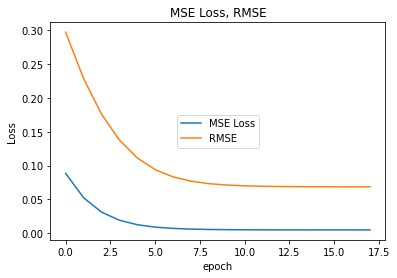

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(history.history["loss"][0:-2])
plt.plot(history.history["root_mean_squared_error"][0:-2])
plt.title("MSE Loss, RMSE")
plt.ylabel("Loss")
plt.xlabel("epoch")
plt.legend(["MSE Loss", "RMSE"], loc="center")
plt.show()

In [13]:
final_RMSE = (history.history['root_mean_squared_error'])[-1]
final_RMSE

0.06844586879014969

In [15]:
from sklearn.metrics import mean_squared_error

#rms = mean_squared_error(y_actual, y_predicted, squared=False)
rms = mean_squared_error(test_rating.to_numpy(), test_pred.reshape((len(test_pred),)), squared=False)
rms
#no regulizar 0.2753604126884709
#with regulizer 0.2750856447278888
#with meta normalization 0.27519455599609355


0.2753066932439757